In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gudhi as gd
from tqdm.notebook import tqdm  # For progressbar


from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams.update({'figure.autolayout': True})

In [2]:
# training
training_file = open('combined_training_info_with_radial_filtrations_9_21.pickle','rb')
training_data = pickle.load(training_file);
training_x = training_data.get('x_data');
training_y = training_data.get('y_data');
training_file.close();

# testing
testing_file = open('combined_testing_info_with_radial_filtrations_9_21.pickle','rb')
testing_data = pickle.load(testing_file);
testing_x = testing_data.get('x_data');
testing_y = testing_data.get('y_data');
testing_file.close();

In [3]:
# optionally reduce feature types during feature extraction
includeGraphFeatures = True;
includeSplineFeatures = False;
includeRadialFeatures = False;
numFeatures = 6

# retrieve features that are defined within this method for any graph that is passed as an argument.
adjustBetti = True
def get_graph_features(combined_data, graph_data, time_index, graph_type = 'water-water'):
    
    # retrieve only a slice of the full simulation time to match the density EC time frame
    start = time_index*200;
    end = (time_index+1)*200;
    
    # retrieve values that were directly extracted from the graph
    betti0 = graph_data.get('betti0')[start:end];
    numEdges = graph_data.get('numEdges')[start:end];
    numVertices= graph_data.get('numVertices')[start:end];
    numWaters = combined_data.get('numWaters');
    numCosolvents = combined_data.get('numCosolvents');
    
    # calculate some values based on those above to use as features
    euler_char = numVertices - numEdges;
    if (adjustBetti):
        if (graph_type == 'water-water'):
            euler_char = numVertices - numEdges;      
        elif (graph_type == 'solute-water'):
            euler_char = numEdges;          
        elif (graph_type == 'cosolvent-water'):
            euler_char = numEdges;          
        elif (graph_type == 'cosolvent-solute'):
            euler_char = numEdges;

    # calculate feature values and return
    vals = [np.mean(euler_char), np.std(euler_char)];
#     vals = [np.mean(euler_char)];
    
    return np.asarray(vals);

def get_all_features(combined_data, y_data):
    
    # variables relevant to every simulation in the set
    numSamples = len(combined_data)
    numTimePoints = combined_data[0].get('ec_data').shape[0]; 
    all_features = [];
    solutes = []
    cosolvents = []
    mass = []
    
    # iterate through each simluation
    for i in tqdm(range(numSamples)):
        
        features_for_sim = [];
        
        # retrieve the graphs for a particular simulation
        graph_ww = combined_data[i].get('water_water_data');
        graph_sw = combined_data[i].get('solute_water_data');
        graph_cw = combined_data[i].get('cosolvent_water_data');
        graph_cs = combined_data[i].get('cosolvent_solute_data');
        
        # for each time point (10) within a simulation:
        for j in range(numTimePoints):
            
            #obtain cosolvent and solute data
            solutes.append(combined_data[i].get('ec_dict').get('solute'))
            cosolvents.append(combined_data[i].get('ec_dict').get('cosolvent'))
            mass.append(combined_data[i].get('ec_dict').get('water_mass_frac'))    
            features_for_time_point = []
                       
            # graph features
            if (includeGraphFeatures):
                graph_features_ww = get_graph_features(combined_data[i], graph_ww, j, graph_type = 'water-water');
                graph_features_sw = get_graph_features(combined_data[i], graph_sw, j, graph_type = 'solute-water');
                graph_features_cw = get_graph_features(combined_data[i], graph_cw, j, graph_type = 'cosolvent-water');
                graph_features_cs = get_graph_features(combined_data[i], graph_cs, j, graph_type = 'cosolvent-solute');
                
                # decide which graph features to include in the final feature consolidation
                graph_features_all = np.concatenate((graph_features_ww, graph_features_sw, graph_features_cs));
                
                features_for_time_point.extend(graph_features_all);
                
            features_for_sim.append(features_for_time_point);
    
        all_features.append(features_for_sim);

    features = np.asarray(all_features);
        
    # reshape the y_values and the features
    y_data_duplicated = np.repeat(y_data,numTimePoints);
    features_2d = features.reshape( (numSamples*numTimePoints, numFeatures) );
    
    return features_2d, y_data_duplicated,solutes,cosolvents,mass;

In [4]:
x_train_g, y_train,train_solutes,train_cosolvents, train_water_percent = get_all_features(training_x, training_y);
x_test_g, y_test, test_solutes, test_cosolvents, test_water_percent = get_all_features(testing_x, testing_y);

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [5]:
#%% LOADING ALL INSTANCES
instances = np.load("MD_Training_Sets.pickle",allow_pickle = True)
test_instances = np.load("MD_Test_Sets.pickle",allow_pickle = True)

In [6]:
x_data = instances[0]
y_data = instances[1]
x_tdata = test_instances[0]
y_tdata = test_instances[1]


In [7]:
x_array = np.asarray(x_data)
x_tarray = np.asarray(x_tdata)

In [8]:
y_data = np.asarray(y_data)
y_tarray = np.asarray(y_tdata)

In [9]:
# returns an entire euler characteristic curve for a given time point over the full range of filtration values
def get_euler_characteristic(data,samples,instindx,y_data):
    curves = []
    filtration_increment = 1e-2;
    numIndices = int(1/filtration_increment) + 1;
    filtrations = np.linspace(0,.2,numIndices)
    label = []
    for j in range(samples):
        euler_characteristic = np.zeros(numIndices);
        dataf = data[j]
        cubeplex = gd.CubicalComplex(dimensions = [np.shape(dataf)[0],np.shape(dataf)[0],np.shape(dataf)[0]],top_dimensional_cells=np.ndarray.flatten(dataf))
        cubeplex.persistence();
        for i in range(numIndices):
            filtration_value = filtrations[i];
            betti_numbers = cubeplex.persistent_betti_numbers(filtration_value,filtration_value);
            euler_characteristic[i] = betti_numbers[0] - betti_numbers[1] + betti_numbers[2];
        curves.append(euler_characteristic)
        label.append(y_data[instindx])
    return curves,label; 

In [10]:
samples = 10
hdim = 1
labels = []
eulcurves = []
chem = []
i = 0
for x in tqdm(x_array):
    x = x[:,:,:,:,0] 
#     eulcurve,label = get_euler_characteristic((x-x.min())/(x.max()-x.min()),samples,i,y_data)
    eulcurve,label = get_euler_characteristic(x,samples,i,y_data)
    labels.append(label)
    eulcurves.append(eulcurve)
    i += 1

  0%|          | 0/76 [00:00<?, ?it/s]

In [11]:
samples = 10
tlabels = []
teulcurves = []
i = 0
for x in tqdm(x_tarray):
    x = x[:,:,:,:,0]
#     eulcurve,label = get_euler_characteristic((x-x.min())/(x.max()-x.min()),samples,i,y_tdata)
    eulcurve,label = get_euler_characteristic(x,samples,i,y_tdata)
    tlabels.append(label)
    teulcurves.append(eulcurve)
    i += 1


  0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
eulcurvez = np.vstack(eulcurves)

alldata = np.hstack([eulcurvez,x_train_g])

# alldata = np.vstack(x_train_g)

labelz = np.hstack(labels)

np.shape(alldata)

(760, 107)

In [13]:
teulcurvez = np.vstack(teulcurves)

talldata = np.hstack([teulcurvez,x_test_g])

# talldata = np.vstack(x_test_g)

tlabelz = np.hstack(tlabels)

np.shape(talldata)

(320, 107)

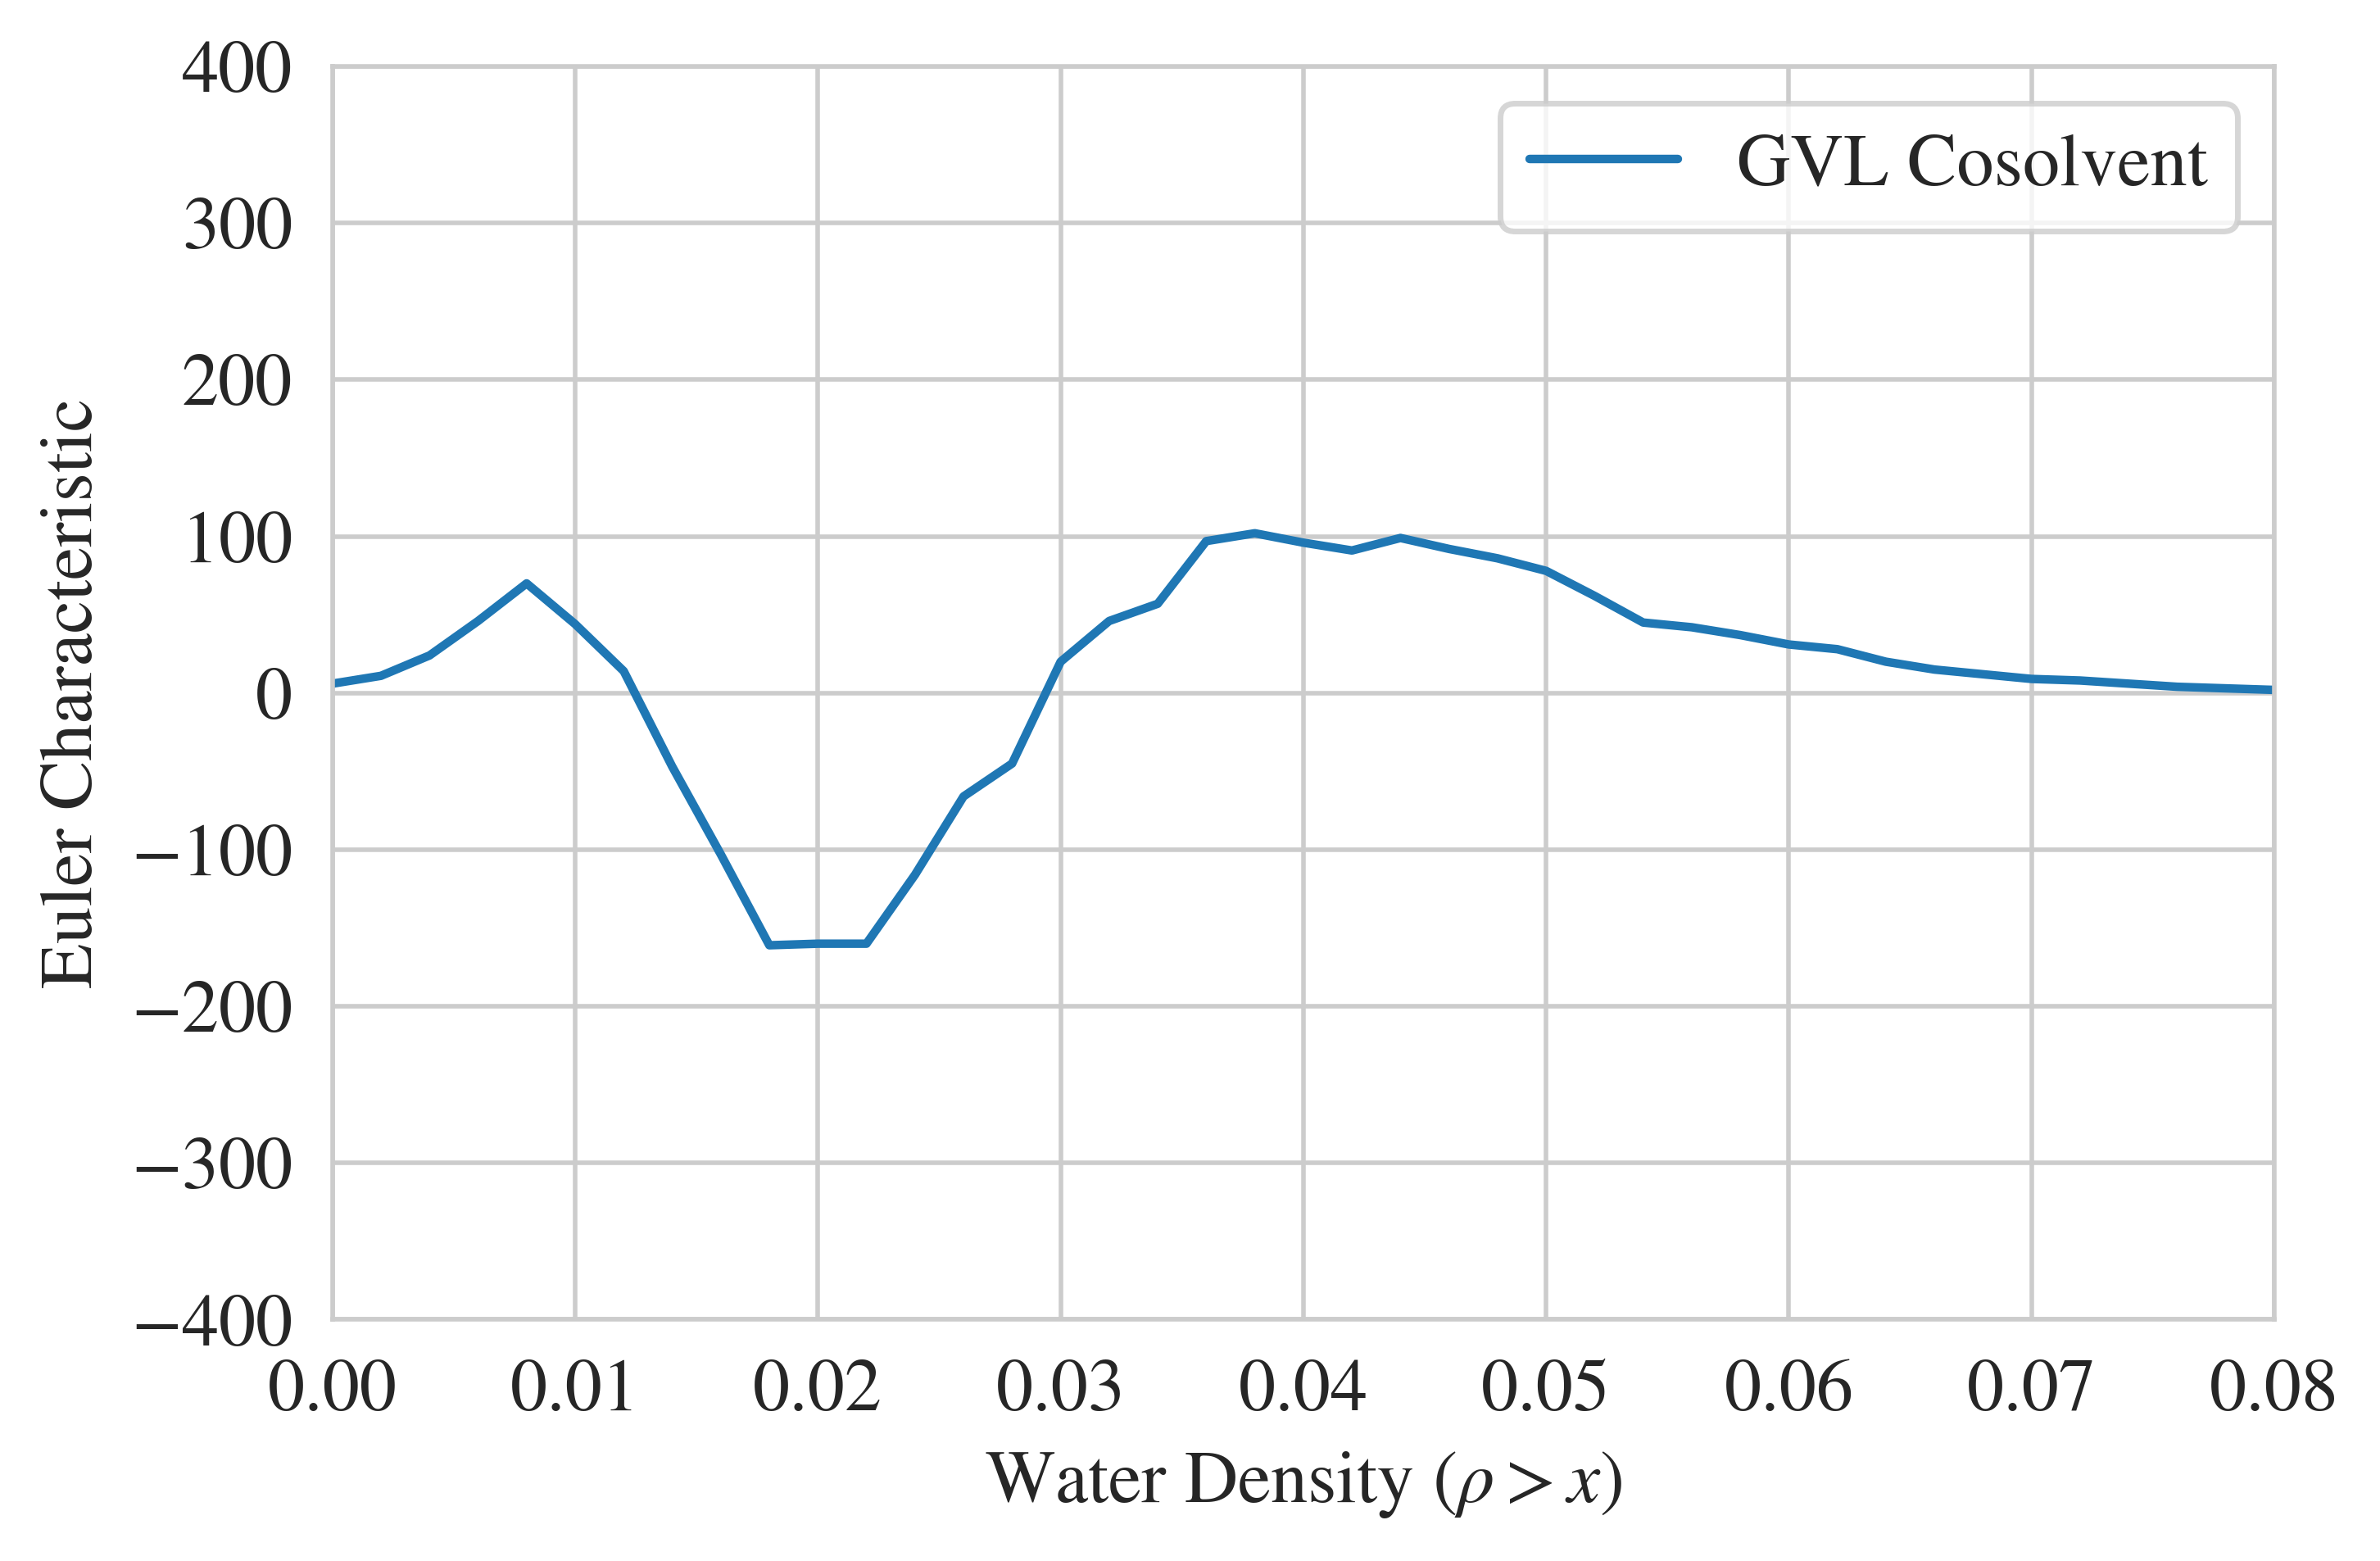

In [14]:
filtration_increment = 1e-2;
numIndices = int(1/filtration_increment) + 1;
filtrations = np.linspace(0,.2,numIndices)

matplotlib.rcParams['font.size'] = 13

i = 4

plt.figure(dpi = 500)

plt.plot(filtrations,eulcurvez[27*(10)+i,:], label = "GVL Cosolvent",c = 'tab:blue')

plt.ylabel("Euler Characteristic")
plt.xlabel(r"Water Density ($\rho > x$)")

plt.xlim(0,.08)
plt.ylim(-400,400)

plt.legend()

plt.savefig("GVL_EC{}.svg".format(i),transparent = True)

In [15]:
descrip_train = np.vstack([train_solutes,train_cosolvents,train_water_percent]).T
descrip_test = np.vstack([test_solutes,test_cosolvents,test_water_percent]).T

In [16]:
mean_t_EC = []
mean_t_g = []
descrip_t_avg = []
label_t_val = []

for i in range(32):
    mean_t_EC.append(np.mean(teulcurvez[i*10:(i+1)*10,:],axis = 0))
    mean_t_g.append(np.mean(x_test_g[i*10:(i+1)*10,:],axis = 0))
    descrip_t_avg.append(descrip_test[i*10])
    label_t_val.append(tlabelz[i*10])
    
mean_EC = []
mean_g = []
descrip_avg = []
label_val = []

for i in range(76):
    mean_EC.append(np.mean(eulcurvez[i*10:(i+1)*10,:],axis = 0))
    mean_g.append(np.mean(x_train_g[i*10:(i+1)*10,:],axis = 0))
    descrip_avg.append(descrip_train[i*10])
    label_val.append(labelz[i*10])

In [17]:
descrip_avg[31]

array(['FRU', 'THF', '10'], dtype='<U5')

In [18]:
descrip_t_avg[-4]

array(['FRU', 'dmso', '10'], dtype='<U5')

In [19]:
descrip_avg[23]

array(['FRU', 'DIO', '10'], dtype='<U5')

In [20]:
descrip_avg[27]

array(['FRU', 'GVL', '10'], dtype='<U5')

In [21]:
descrip_t_avg[-13]

array(['FRU', 'ACN', '10'], dtype='<U5')

In [22]:
filtration_increment = 1e-2;
numIndices = int(1/filtration_increment) + 1;
filtrations = np.linspace(0,.2,numIndices)

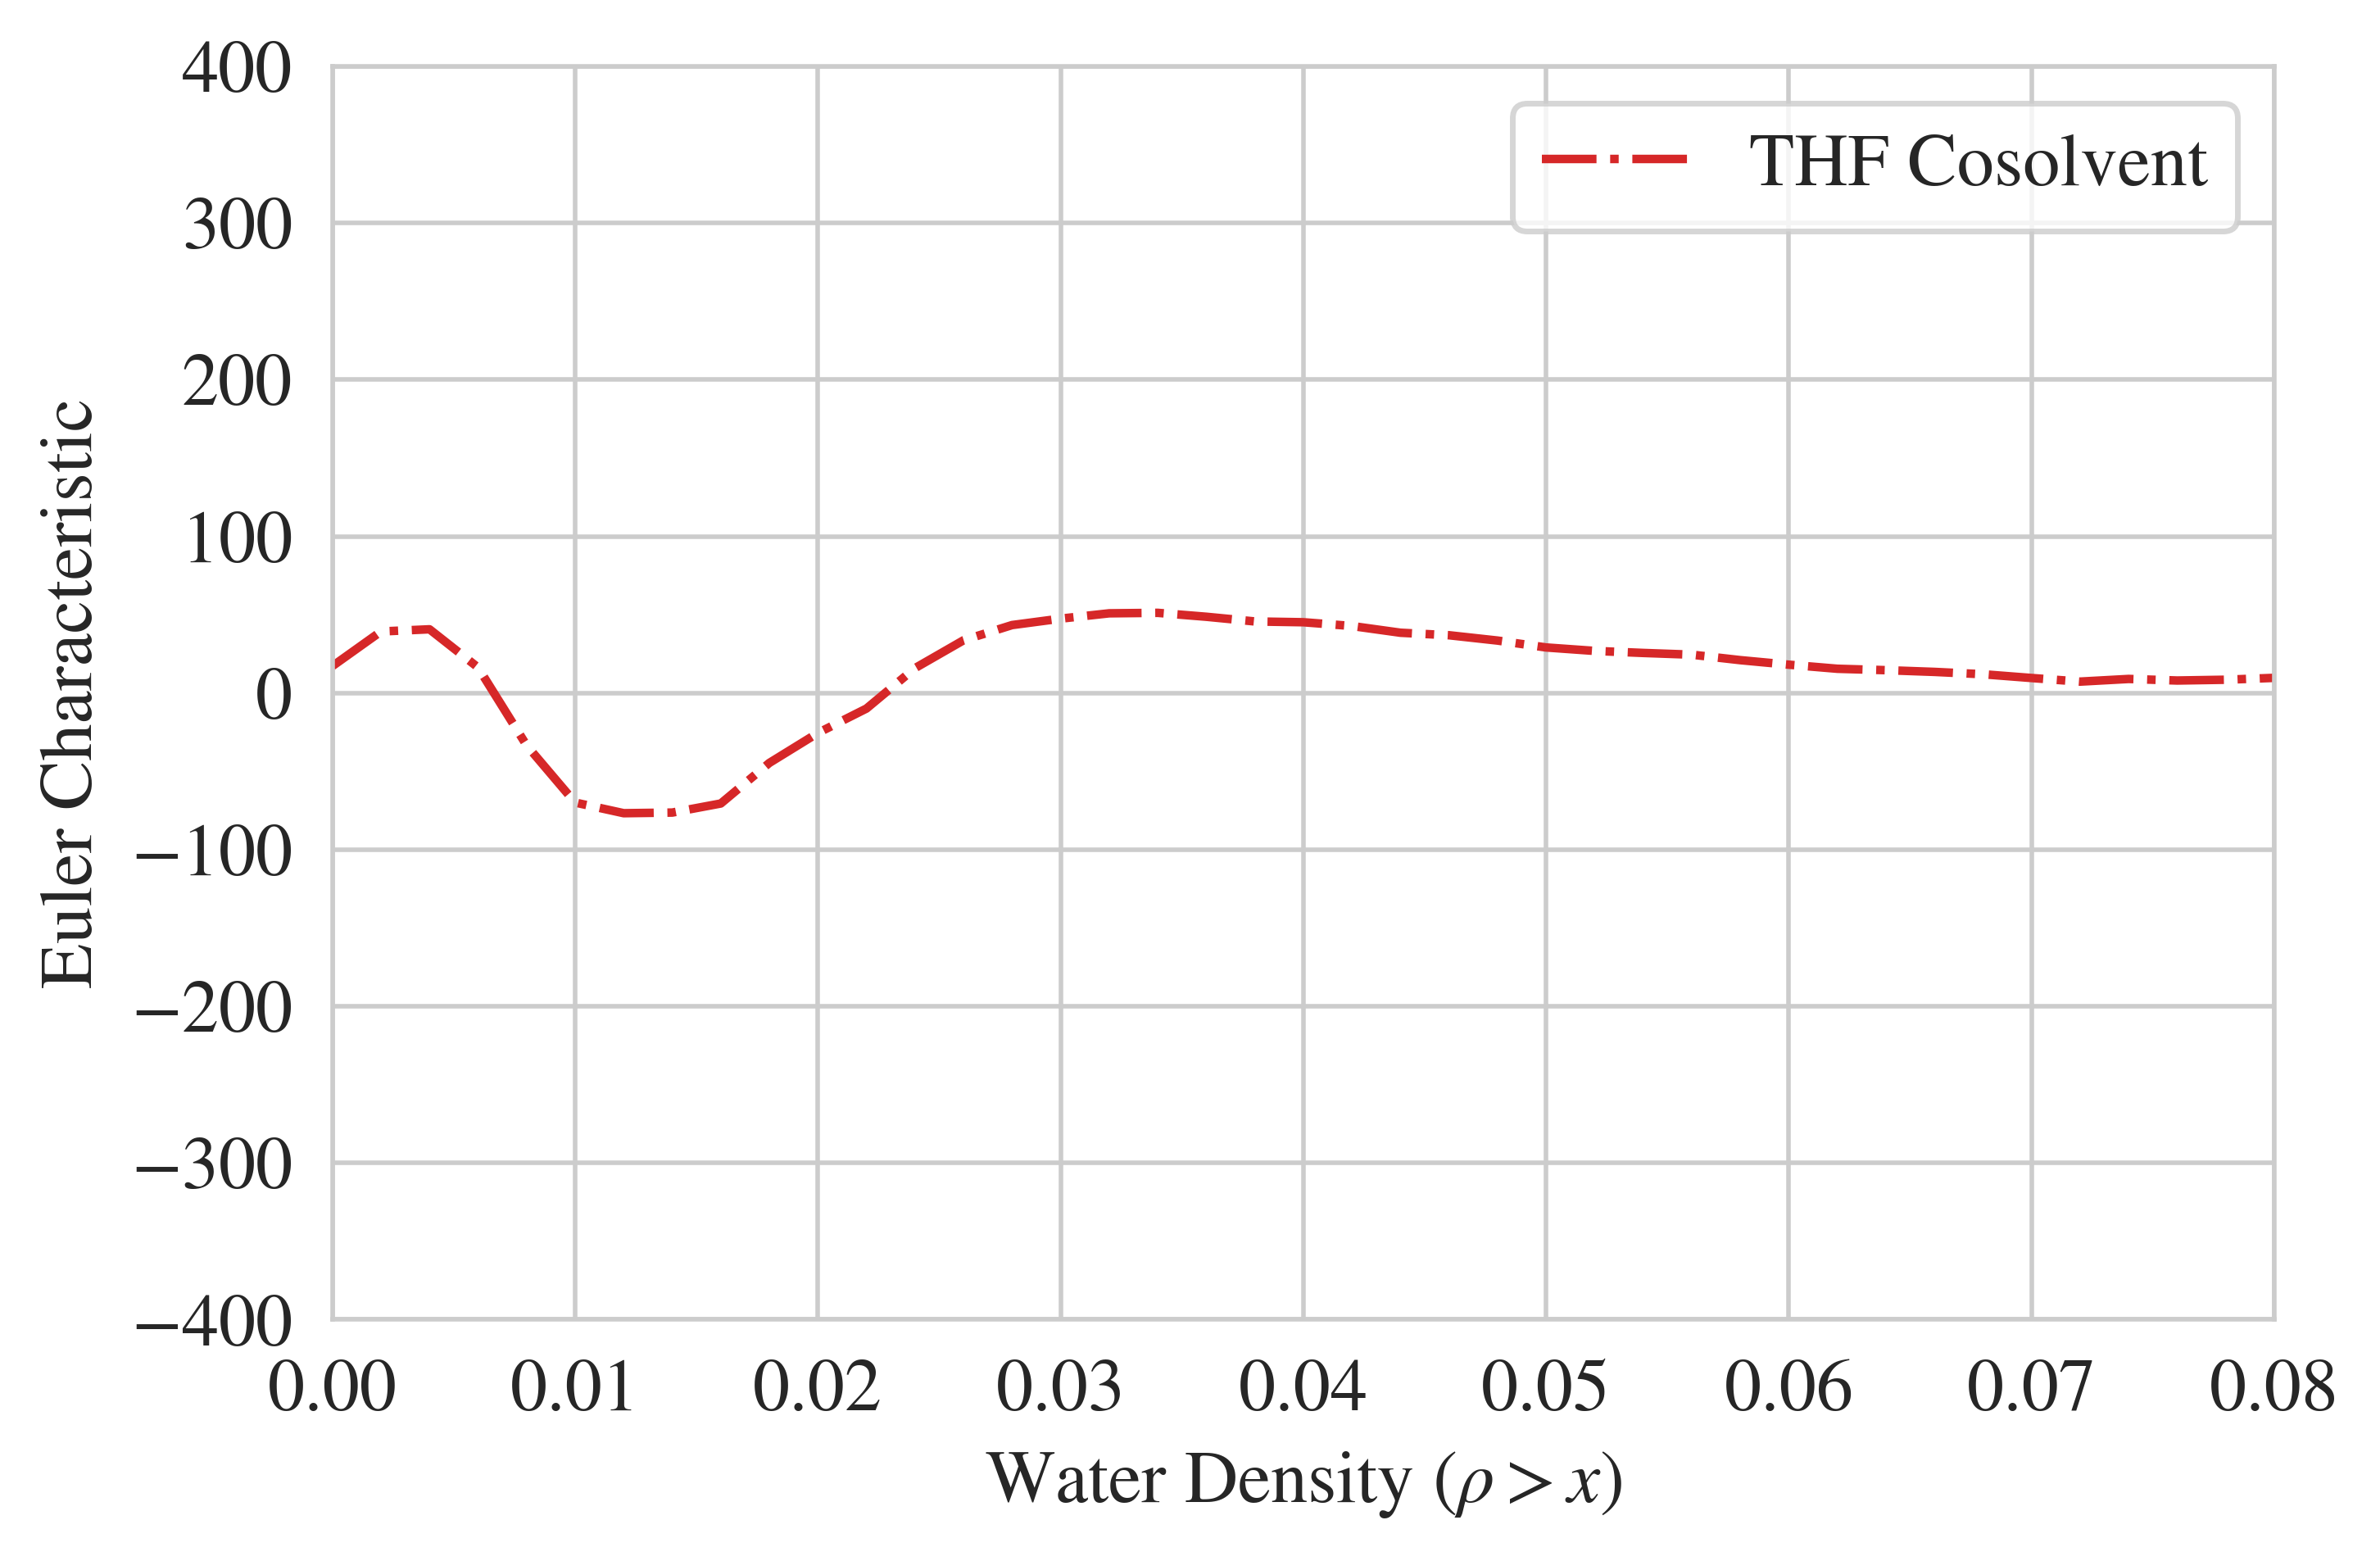

In [23]:
matplotlib.rcParams['font.size'] = 13

plt.figure(dpi = 500)

plt.plot(filtrations,mean_EC[31], '-.',label = "THF Cosolvent", c = 'tab:red')

plt.ylabel("Euler Characteristic")
plt.xlabel(r"Water Density ($\rho > x$)")

plt.xlim(0,.08)

plt.ylim(-400,400)

plt.legend()

plt.savefig("THF_EC.svg")

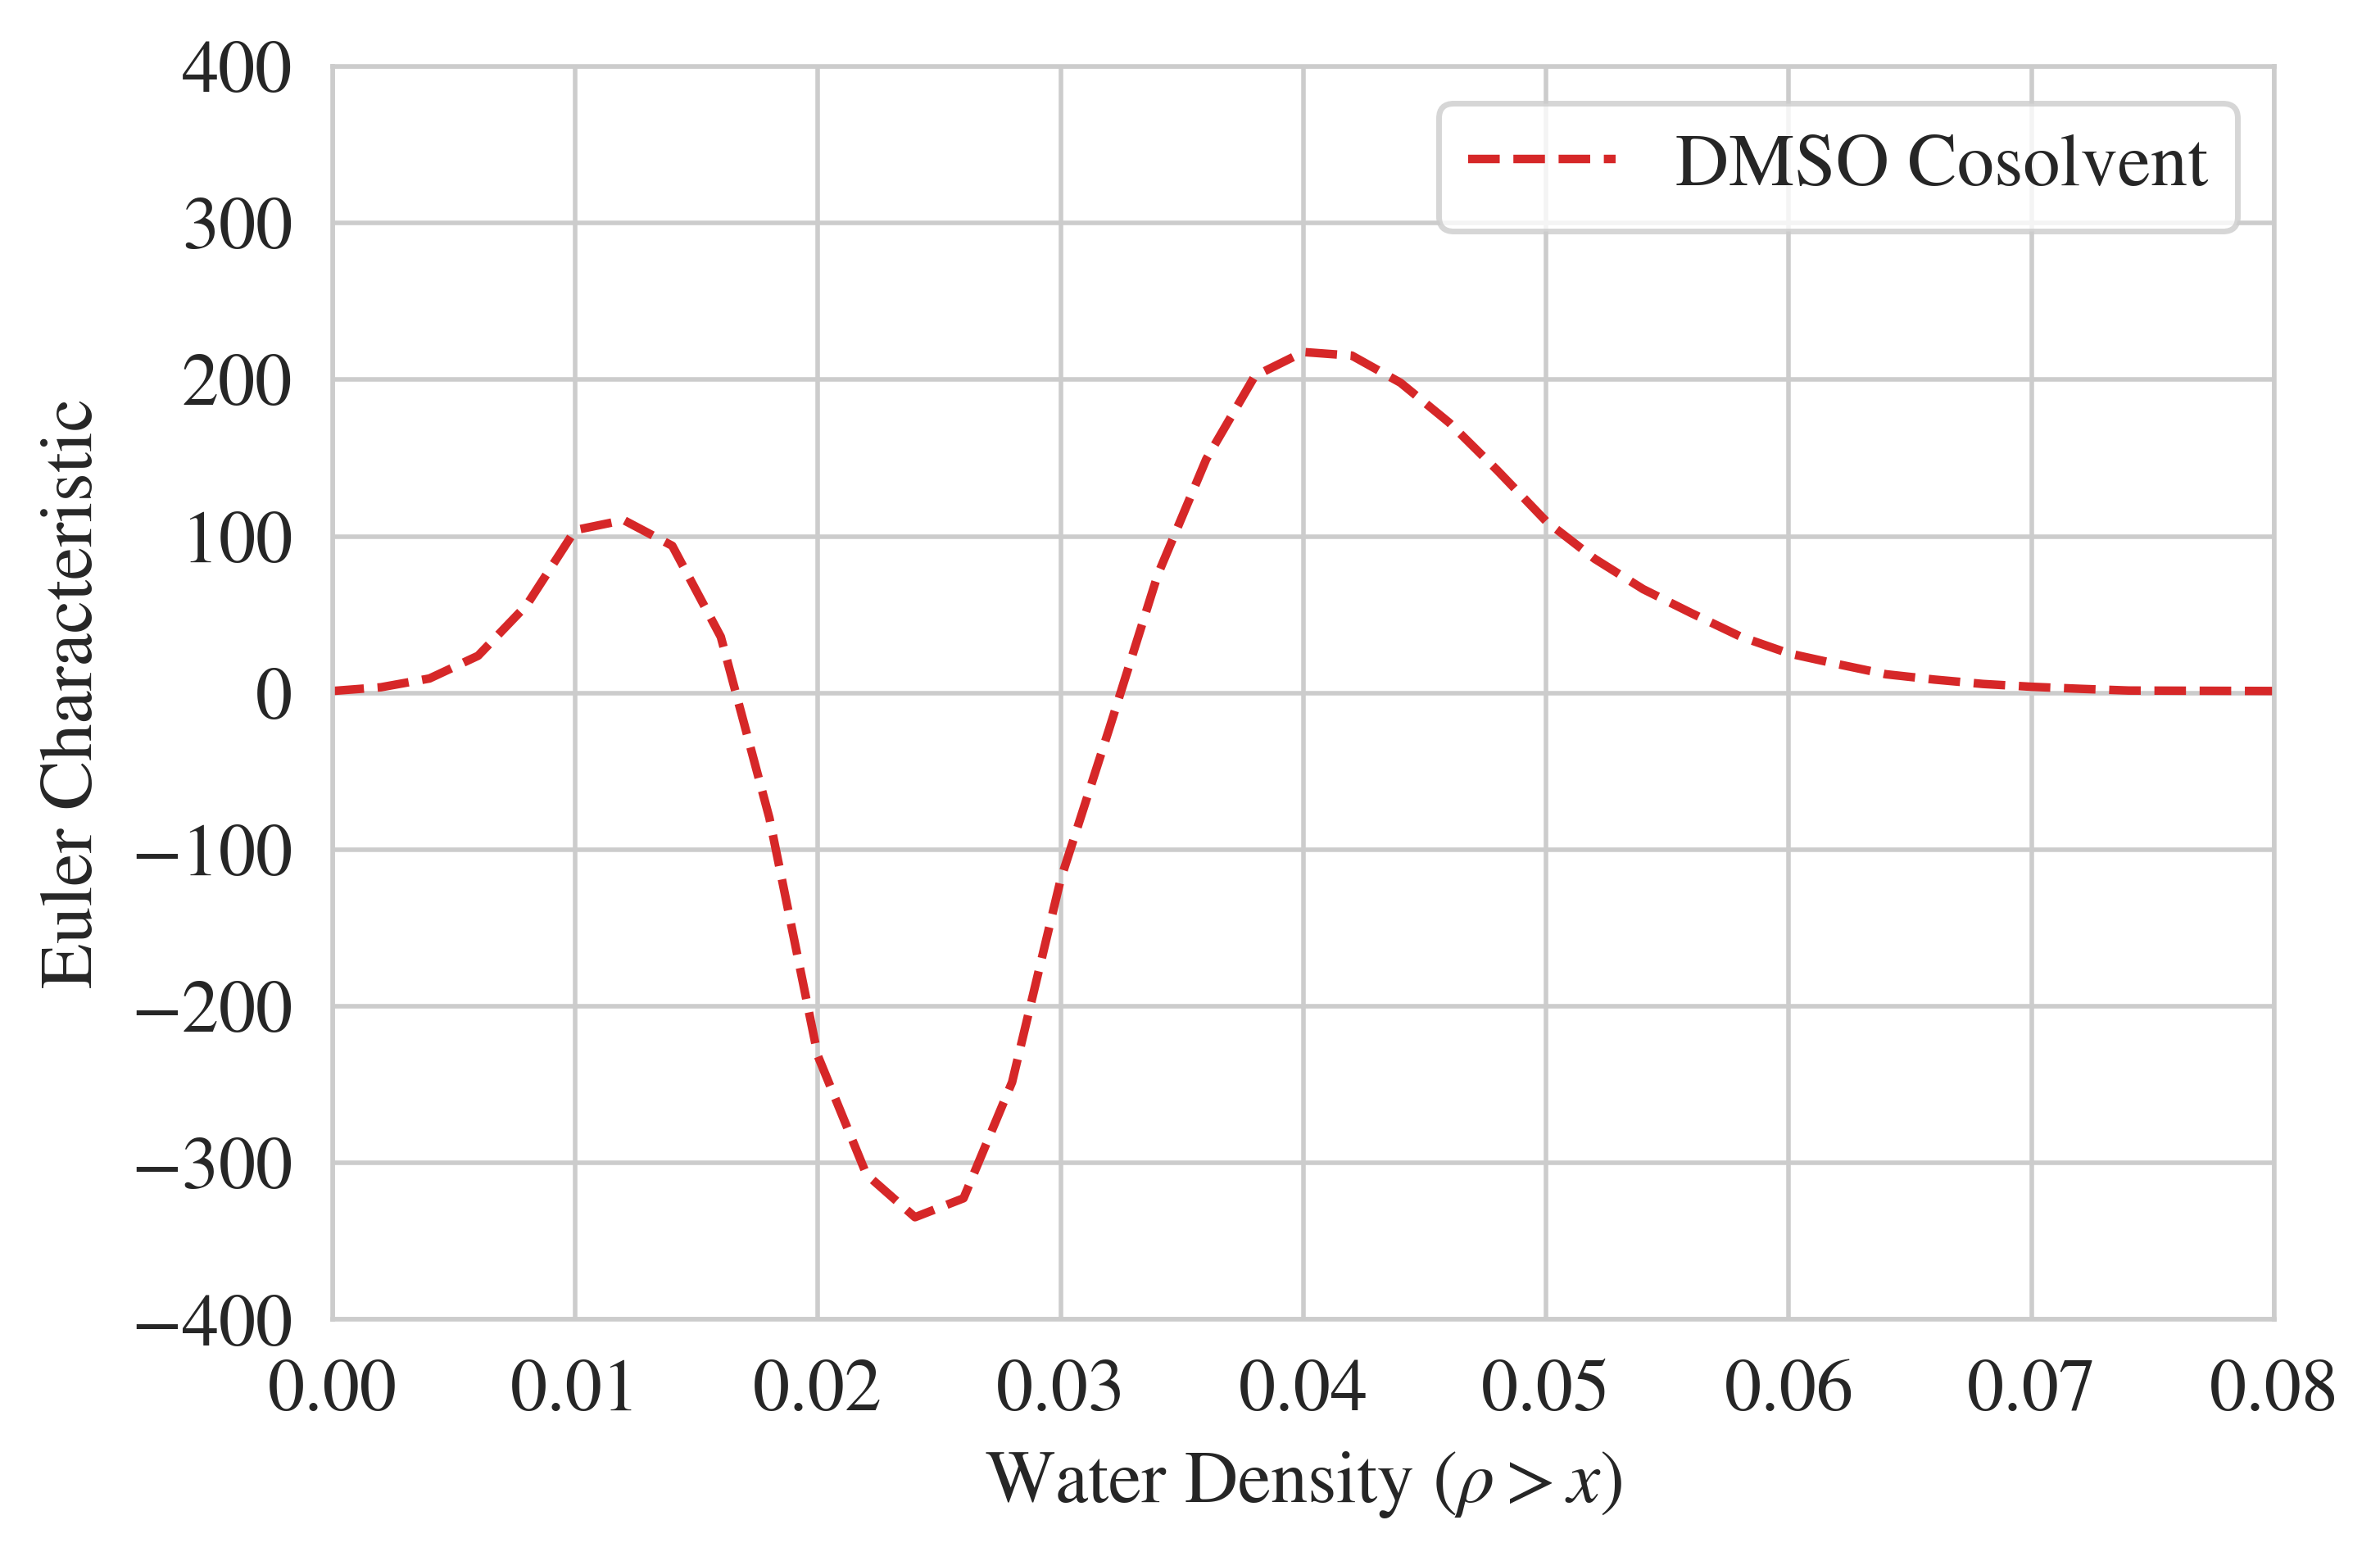

In [24]:
matplotlib.rcParams['font.size'] = 13

plt.figure(dpi = 500)

# plt.plot(filtrations,mean_EC[31], label = "THF Cosolvent", c = 'tab:red')
plt.plot(filtrations,mean_t_EC[-4], '--',label = "DMSO Cosolvent",c = 'tab:red')

plt.ylabel("Euler Characteristic")
plt.xlabel(r"Water Density ($\rho > x$)")

plt.xlim(0,.08)
plt.ylim(-400,400)

plt.legend()

plt.savefig("DMSO_EC.svg")

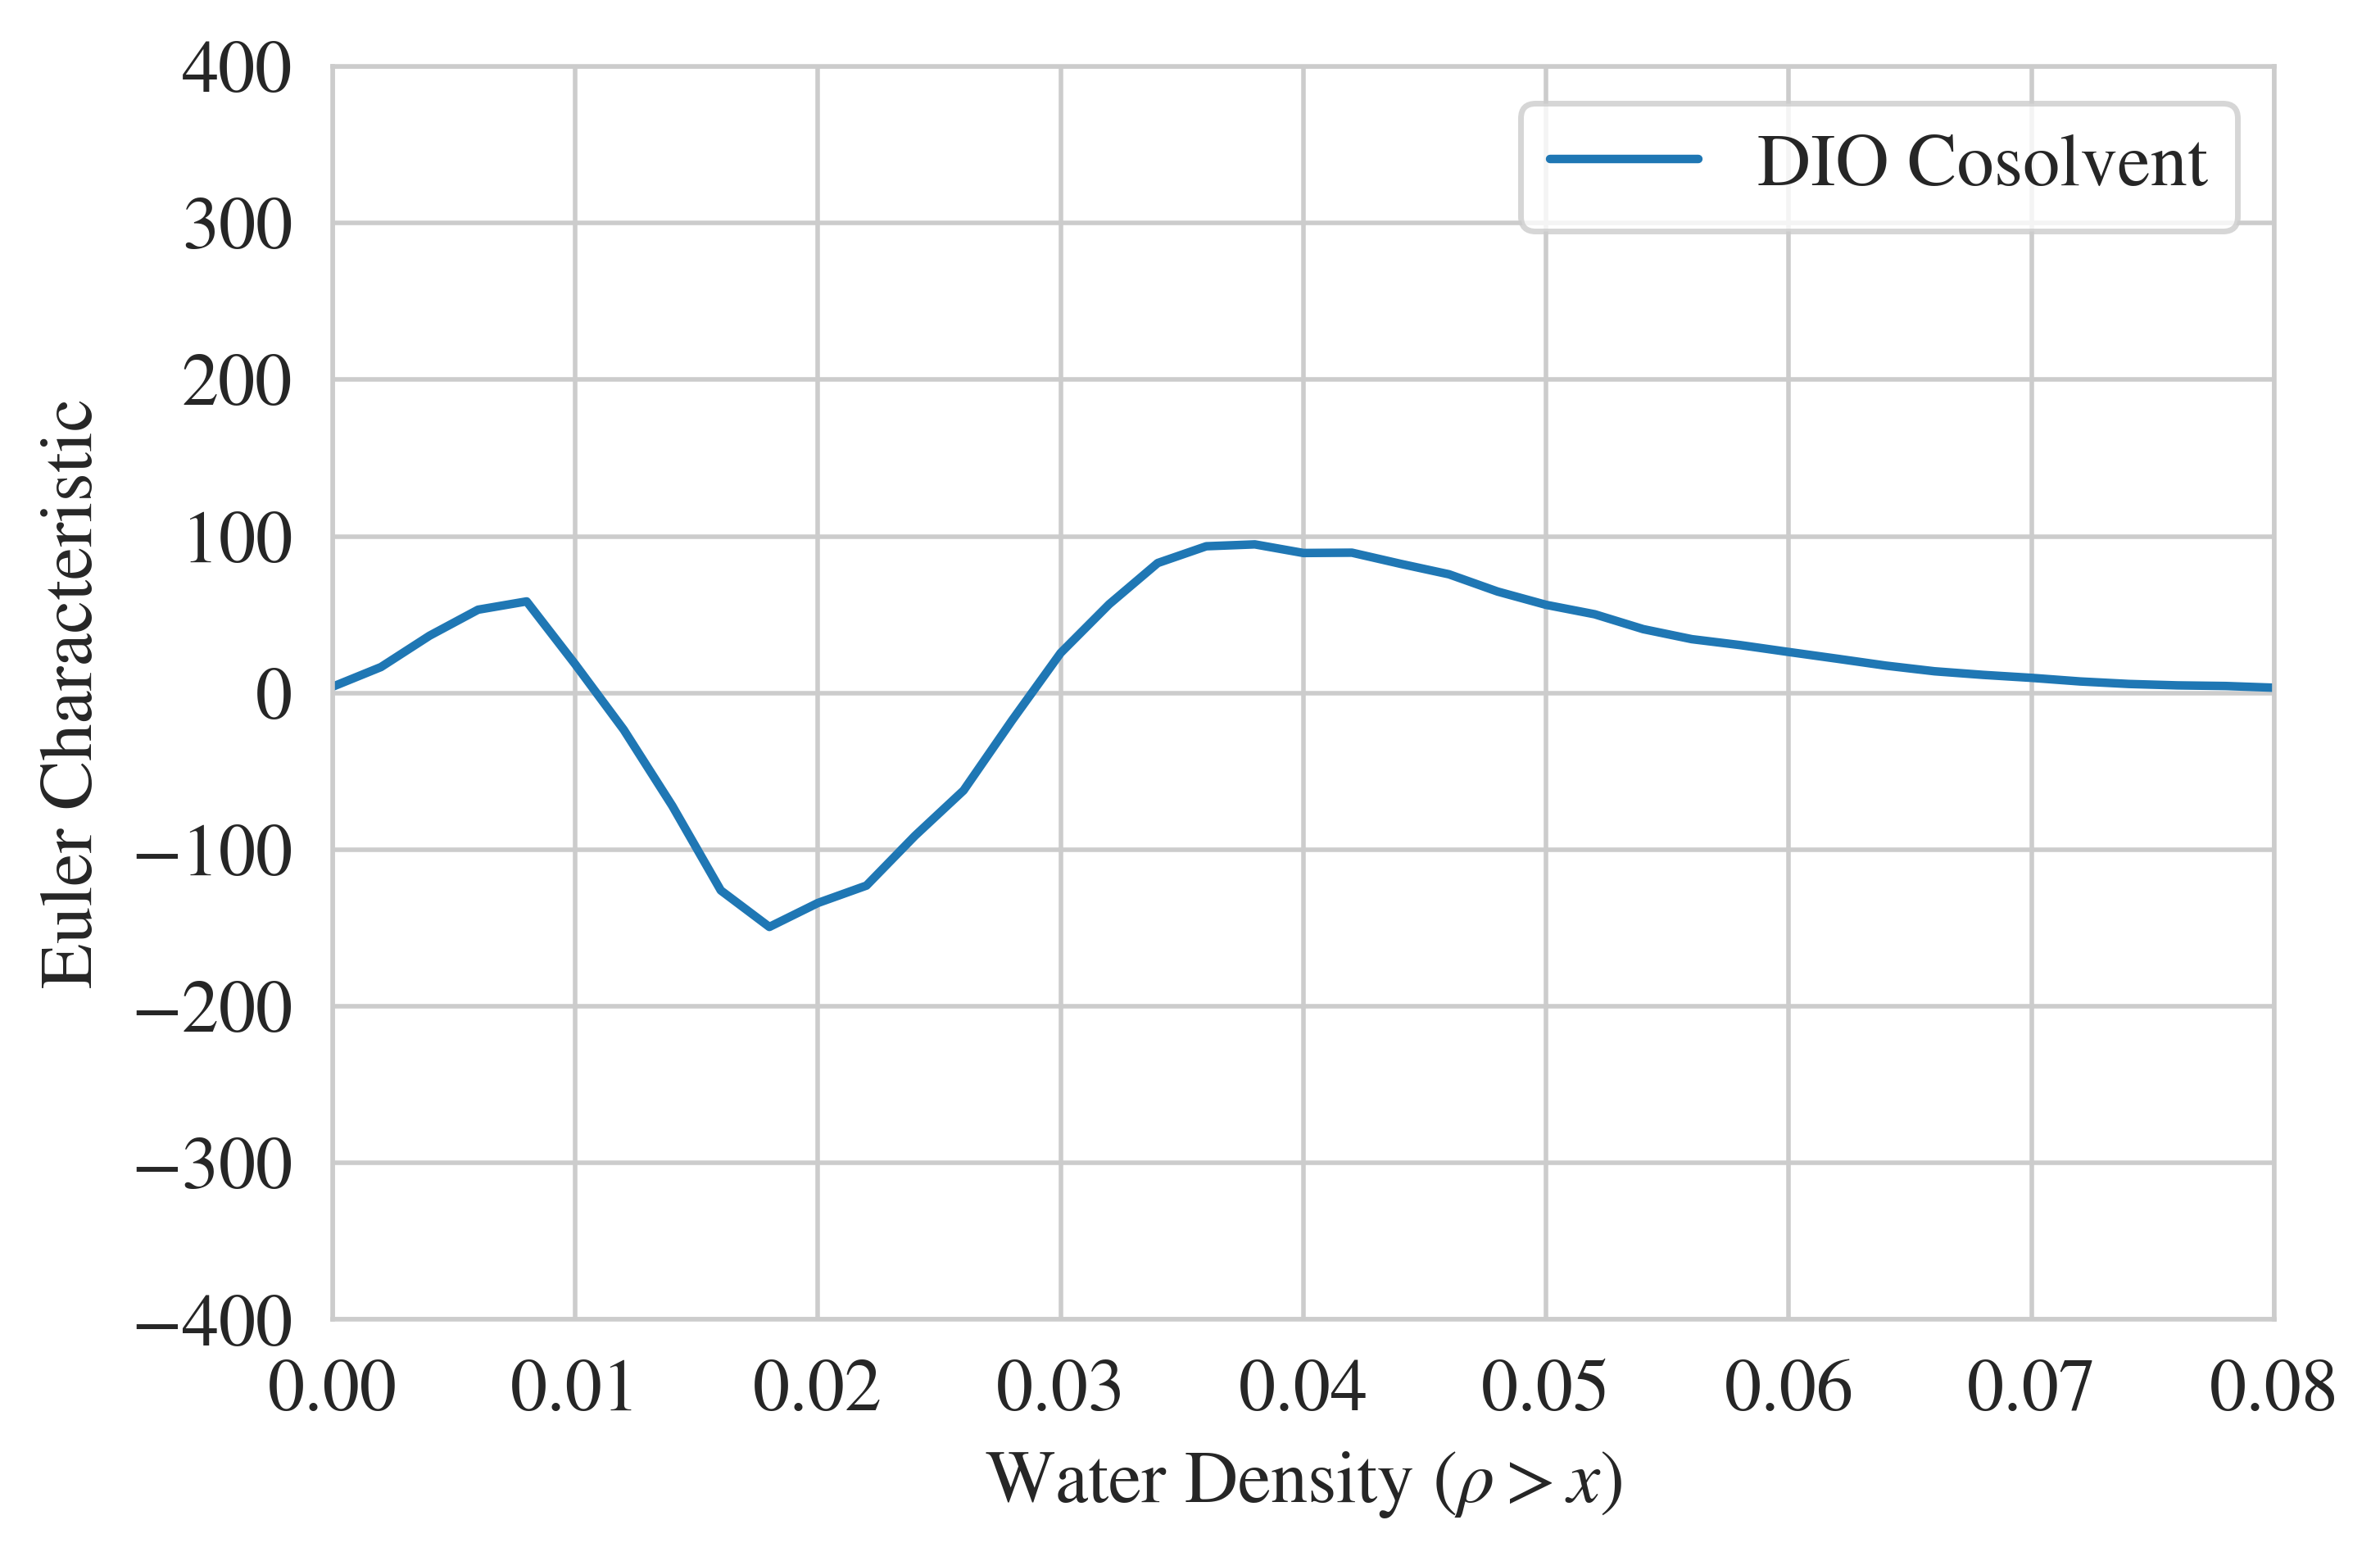

In [25]:
matplotlib.rcParams['font.size'] = 13

plt.figure(dpi = 500)

plt.plot(filtrations,mean_EC[23], label = "DIO Cosolvent",c = 'tab:blue')

plt.ylabel("Euler Characteristic")
plt.xlabel(r"Water Density ($\rho > x$)")

plt.xlim(0,.08)
plt.ylim(-400,400)

plt.legend()

plt.savefig("DIO_EC.svg")

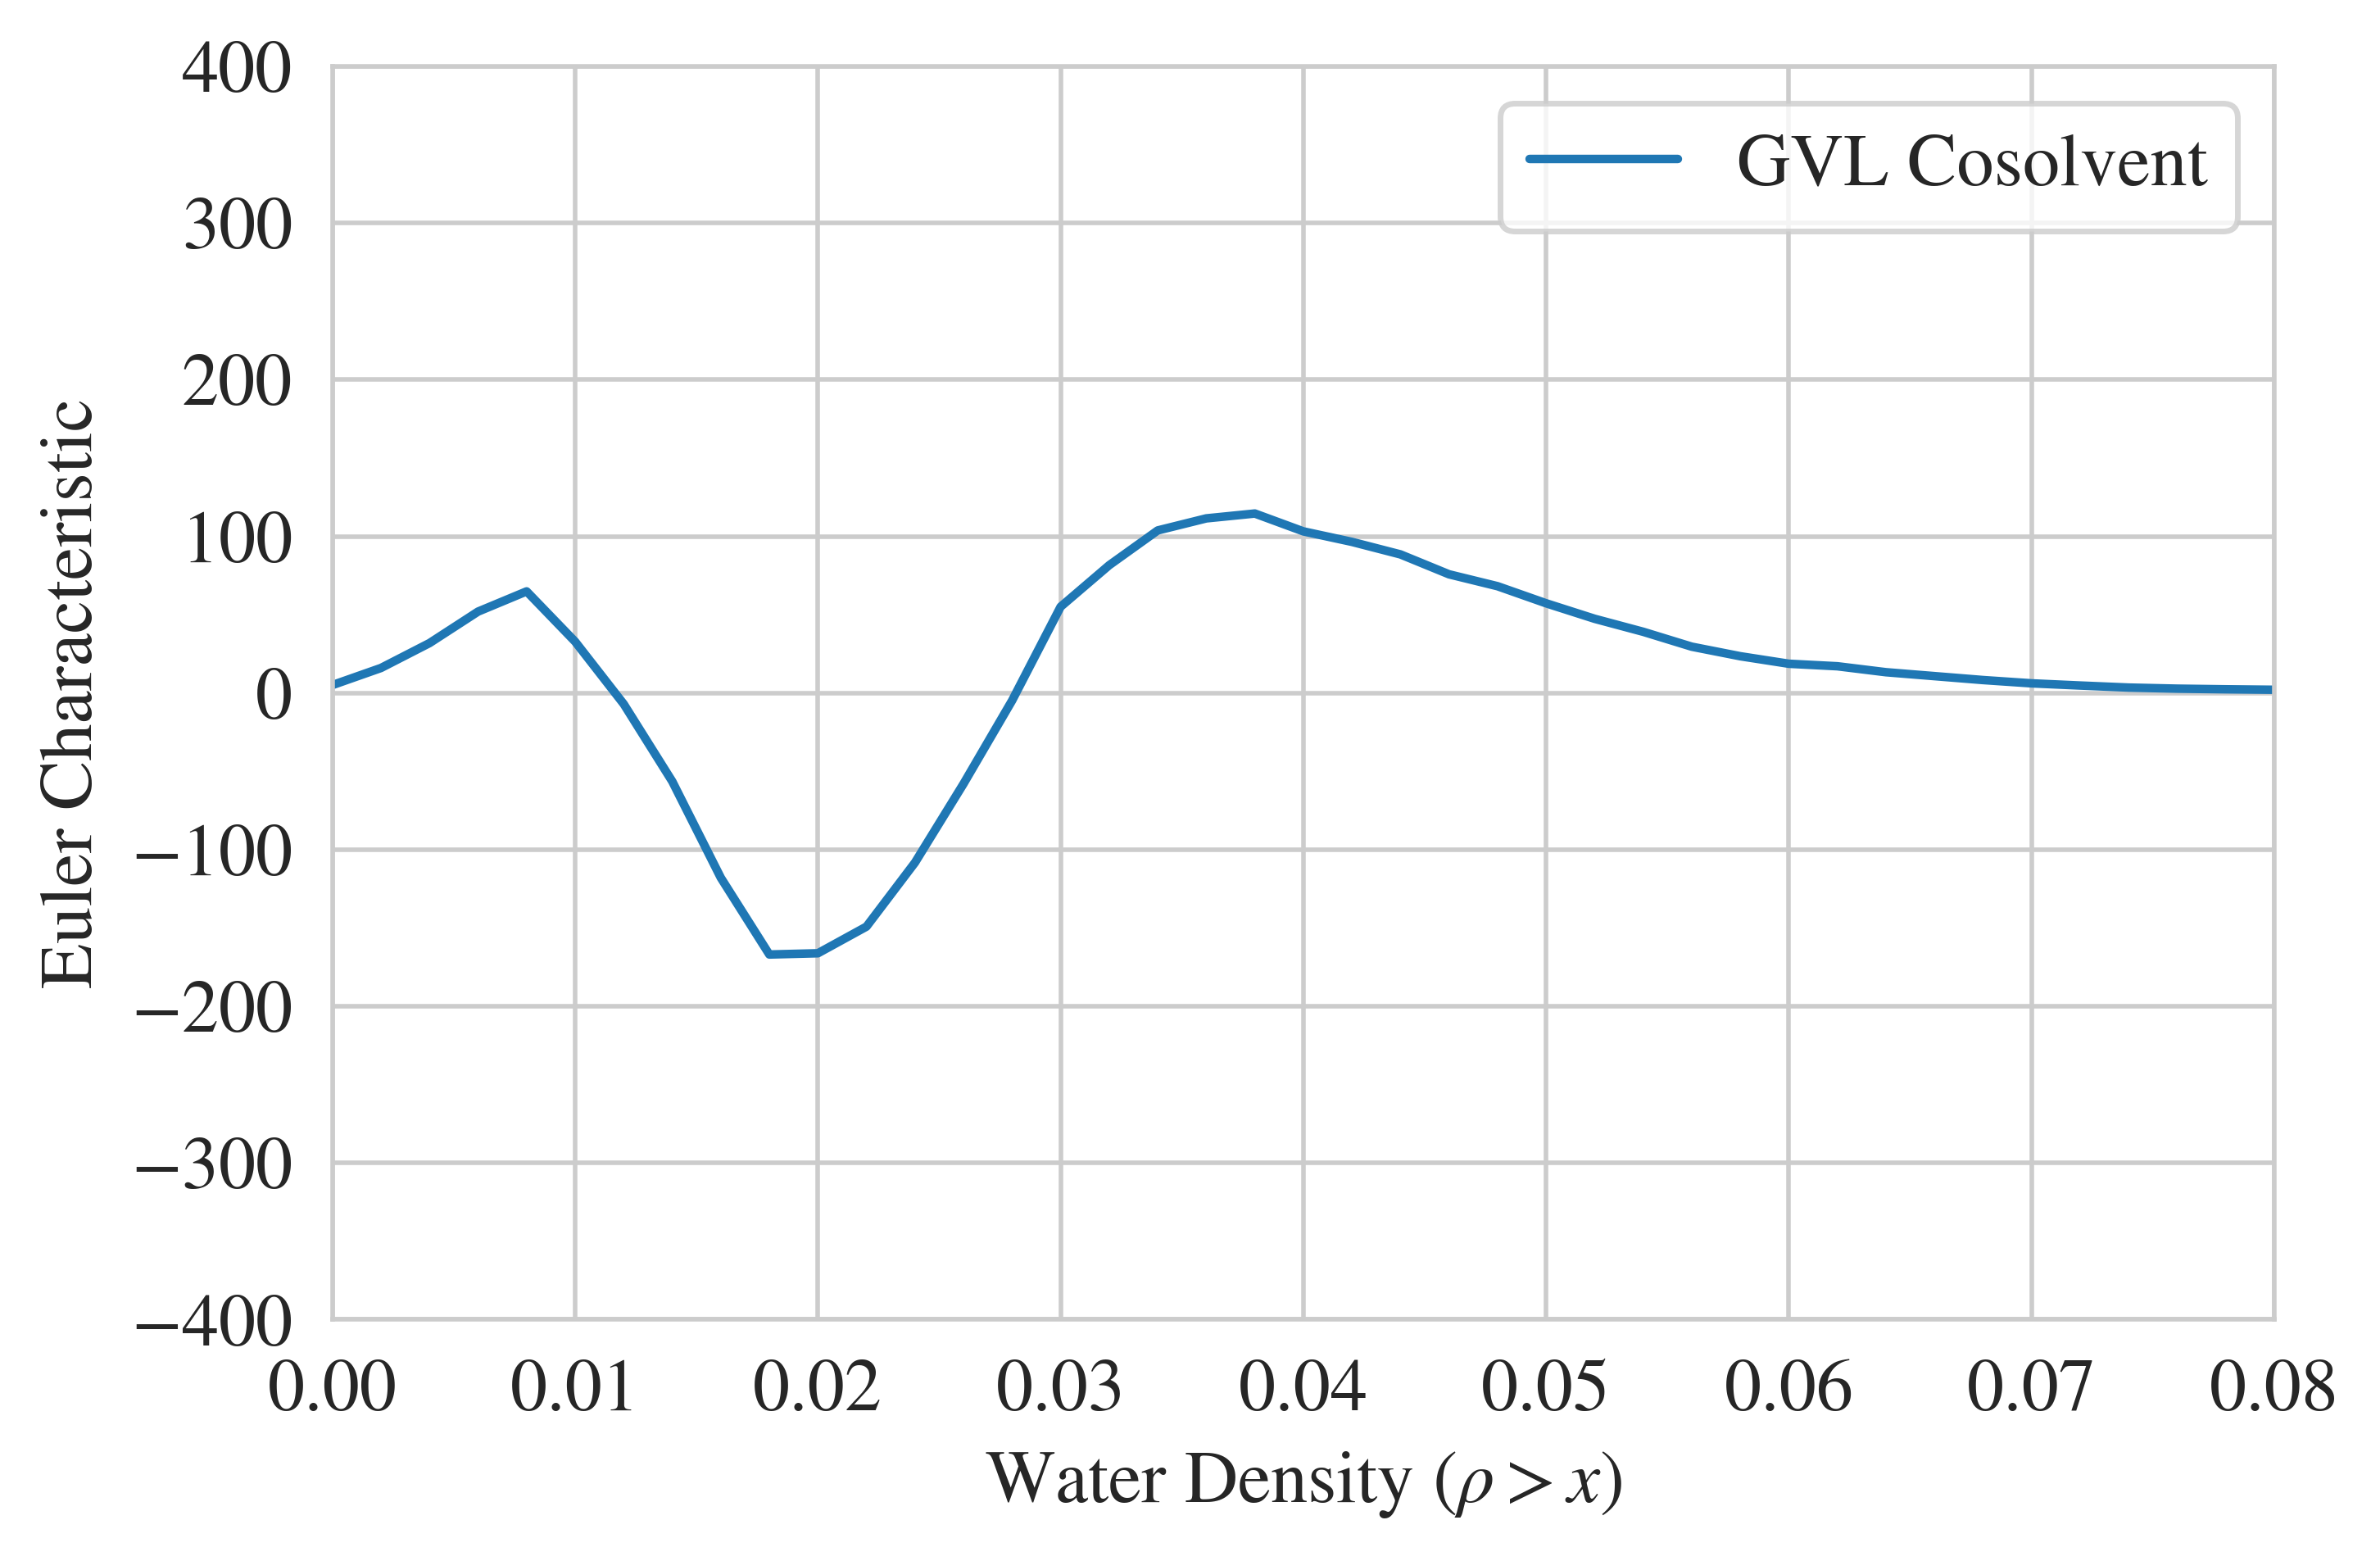

In [26]:
matplotlib.rcParams['font.size'] = 13

plt.figure(dpi = 500)

plt.plot(filtrations,mean_EC[27], label = "GVL Cosolvent",c = 'tab:blue')

plt.ylabel("Euler Characteristic")
plt.xlabel(r"Water Density ($\rho > x$)")

plt.xlim(0,.08)
plt.ylim(-400,400)

plt.legend()

plt.savefig("GVL_EC.svg")

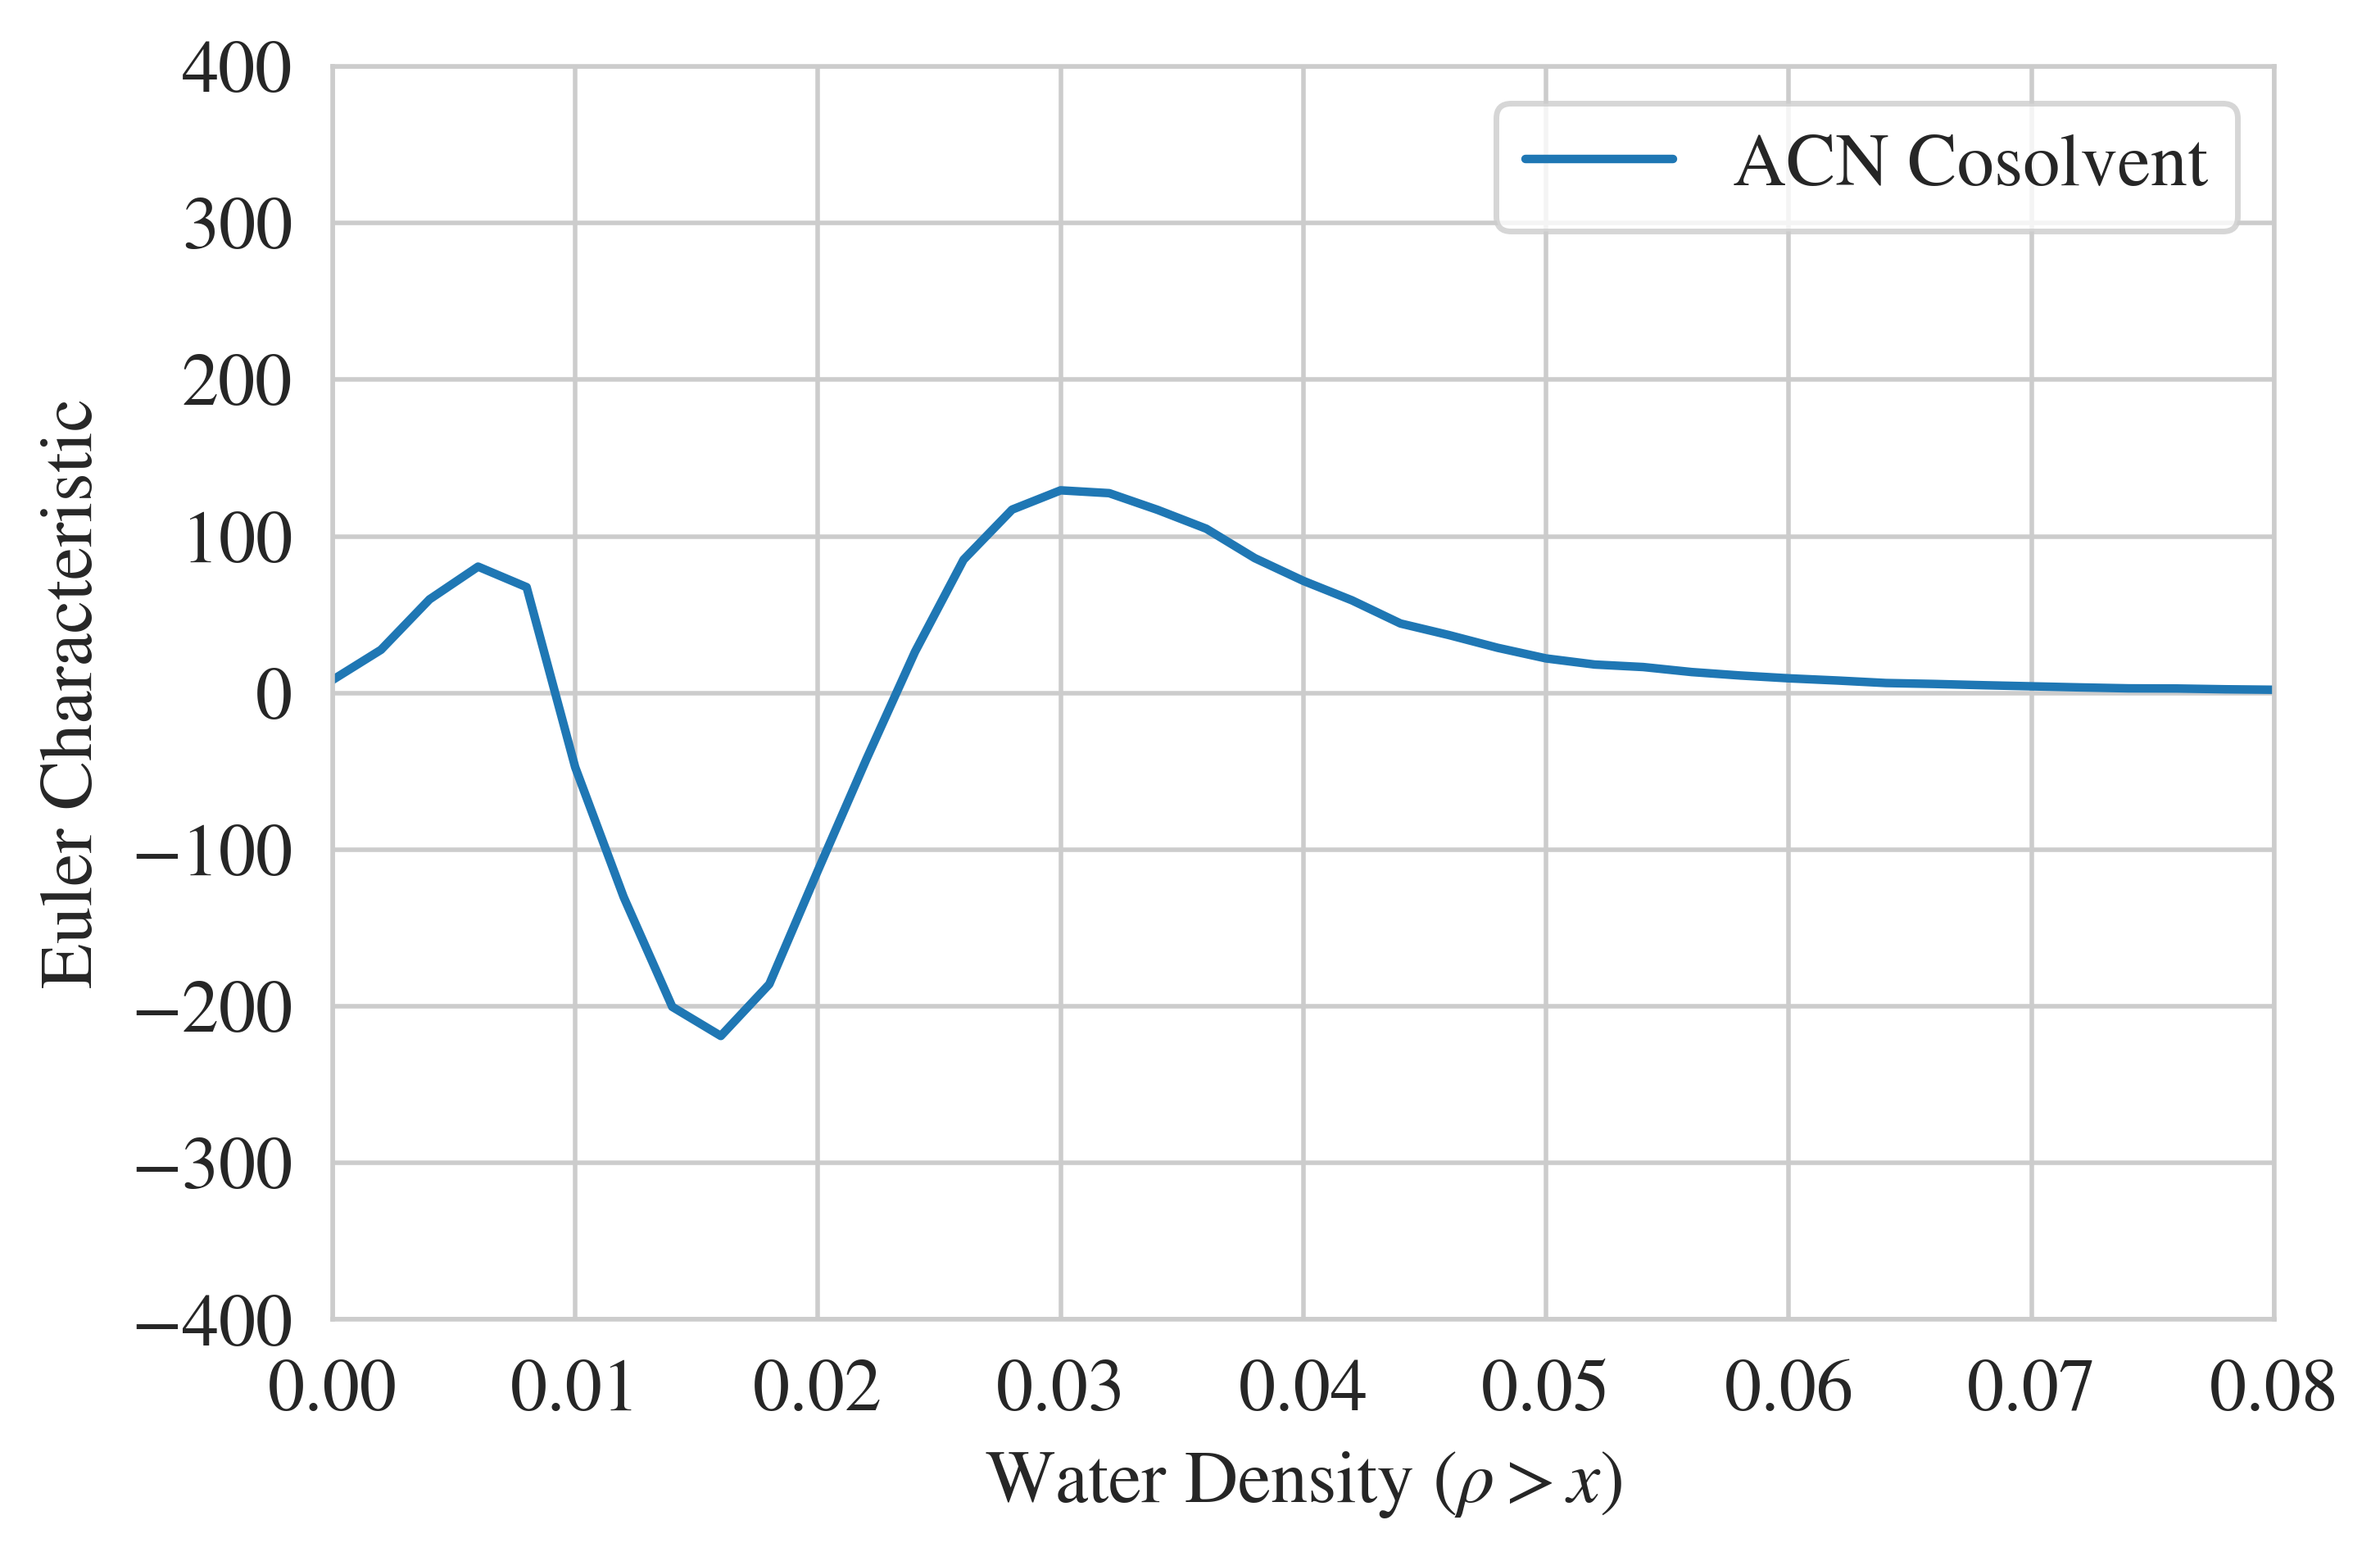

In [27]:
matplotlib.rcParams['font.size'] = 13

plt.figure(dpi = 500)

plt.plot(filtrations,mean_t_EC[-13], label = "ACN Cosolvent",c = 'tab:blue')

plt.ylabel("Euler Characteristic")
plt.xlabel(r"Water Density ($\rho > x$)")

plt.xlim(0,.08)
plt.ylim(-400,400)

plt.legend()

plt.savefig("ACN_EC.svg")

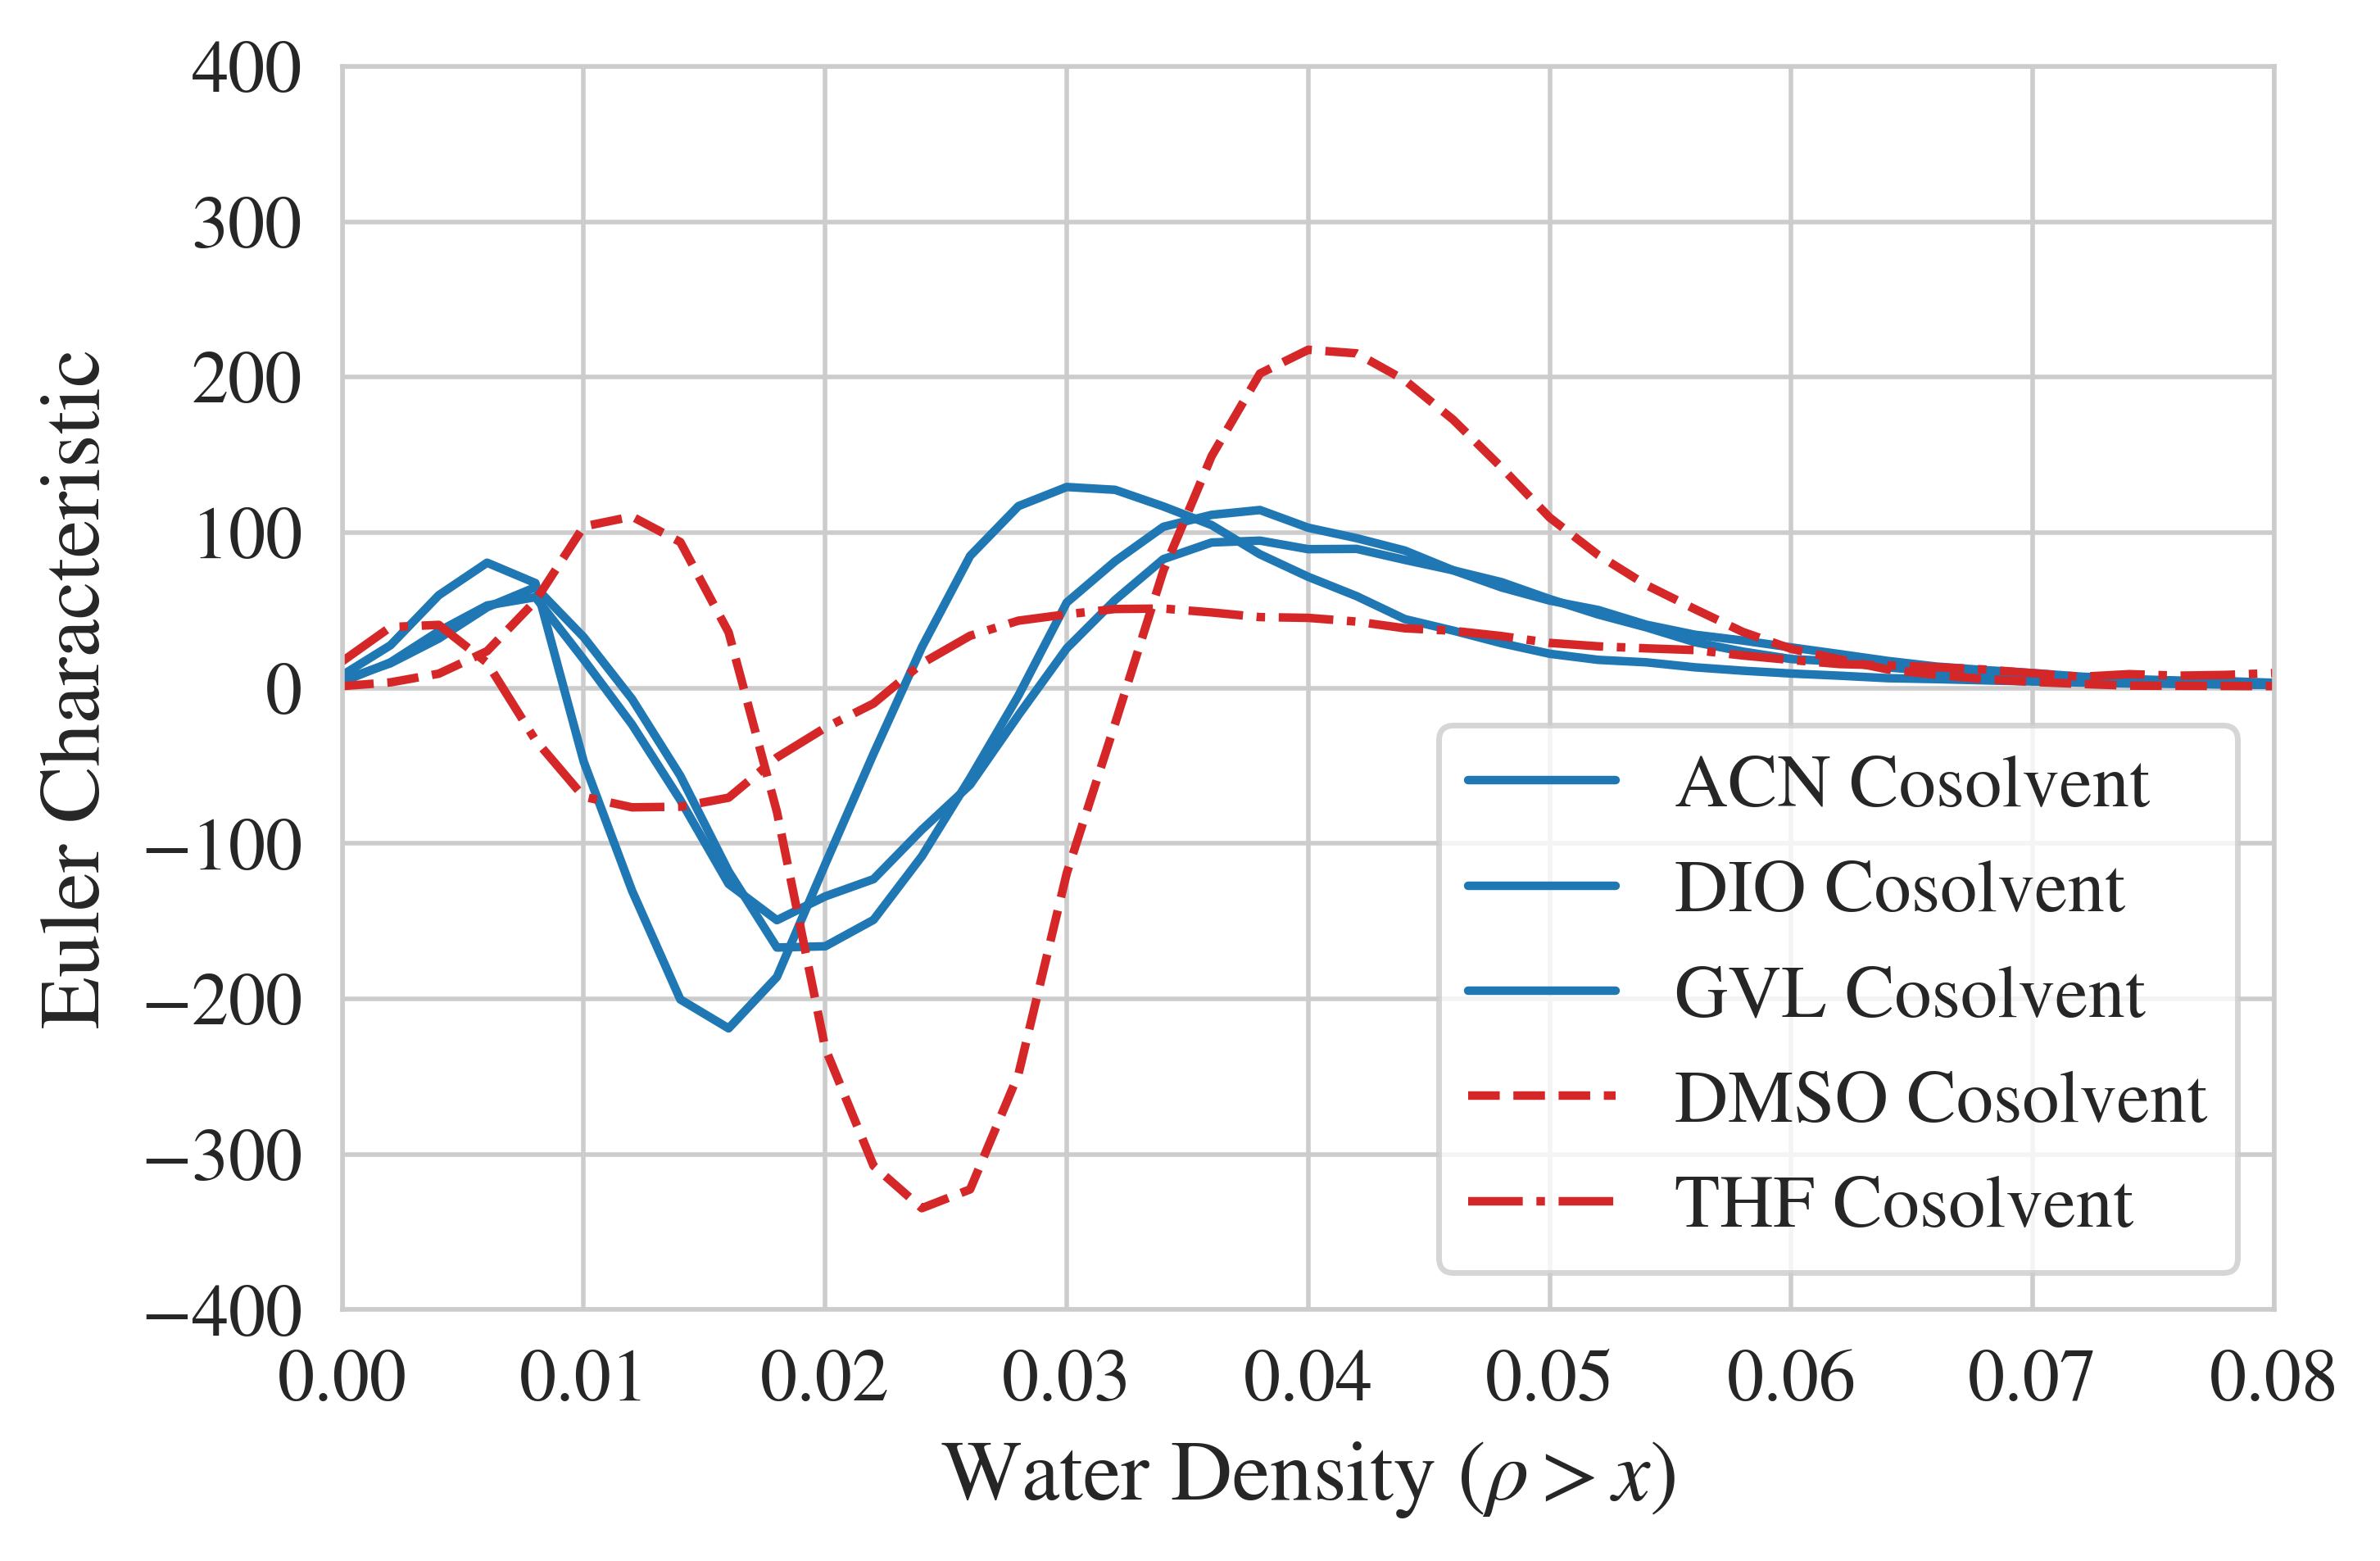

In [28]:
matplotlib.rcParams['font.size'] = 13

plt.figure(dpi = 500)

plt.plot(filtrations,mean_t_EC[-13], label = "ACN Cosolvent",c = 'tab:blue')

plt.plot(filtrations,mean_EC[23], label = "DIO Cosolvent",c = 'tab:blue')

plt.plot(filtrations,mean_EC[27], label = "GVL Cosolvent",c = 'tab:blue')

plt.plot(filtrations,mean_t_EC[-4], '--',label = "DMSO Cosolvent",c = 'tab:red')

plt.plot(filtrations,mean_EC[31], '-.',label = "THF Cosolvent", c = 'tab:red')

plt.xlim(0,.08)
plt.ylim(-400,400)

plt.legend()

plt.ylabel("Euler Characteristic",fontsize = 15)
plt.xlabel(r"Water Density ($\rho > x$)", fontsize = 15)

plt.savefig("All_EC.svg")